In [13]:
import polars as pl

Let's read in our csv which has game info from 1899-2024

In [14]:
df = pl.read_csv("data/allseasonsgameinfo.csv", infer_schema_length=1000000)

## Data Prep

In [15]:
print(df.shape)
df.head()

(212555, 43)


gid,visteam,hometeam,site,date,number,starttime,daynight,innings,tiebreaker,usedh,htbf,timeofgame,attendance,fieldcond,precip,sky,temp,winddir,windspeed,oscorer,forfeit,suspend,umphome,ump1b,ump2b,ump3b,umplf,umprf,wp,lp,save,gametype,vruns,hruns,wteam,lteam,line,batteries,lineups,box,pbp,season
str,str,str,str,i64,i64,str,str,i64,i64,bool,bool,i64,i64,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,str,str,str,i64
"""LS3189904140""","""CHN""","""LS3""","""LOU03""",18990414,0,"""0:00PM""","""day""",null,null,false,null,113,11500,"""unknown""","""unknown""","""unknown""","""0""","""unknown""","""-1""",null,null,null,"""burno101""","""warna901""",null,null,null,null,"""grifc101""","""cunnb103""",null,"""regular""",15,1,"""CHN""","""LS3""","""y""","""both""","""y""","""y""",null,1899
"""PHI189904140""","""WSN""","""PHI""","""PHI09""",18990414,0,"""0:00PM""","""day""",null,null,false,null,120,12000,"""unknown""","""unknown""","""unknown""","""0""","""unknown""","""-1""",null,null,null,"""huntj901""","""connt901""",null,null,null,null,"""piatw101""","""killf101""",null,"""regular""",5,6,"""PHI""","""WSN""","""y""","""both""","""y""","""y""",null,1899
"""BLN189904150""","""NY1""","""BLN""","""BAL07""",18990415,0,"""0:00PM""","""day""",null,null,false,null,130,3912,"""unknown""","""unknown""","""unknown""","""0""","""unknown""","""-1""",null,null,null,"""emslb101""","""bettw901""",null,null,null,null,"""kitsf101""","""dohee101""",null,"""regular""",3,5,"""BLN""","""NY1""","""y""","""both""","""y""","""y""",null,1899
"""BRO189904150""","""BSN""","""BRO""","""NYC12""",18990415,0,"""0:00PM""","""day""",null,null,false,null,120,20167,"""unknown""","""unknown""","""unknown""","""0""","""unknown""","""-1""",null,null,null,"""andre101""","""gaffj801""",null,null,null,null,"""nichk101""","""kennb101""",null,"""regular""",1,0,"""BSN""","""BRO""","""y""","""both""","""y""","""y""",null,1899
"""CIN189904150""","""PIT""","""CIN""","""CIN05""",18990415,0,"""0:00PM""","""day""",null,null,false,null,130,10000,"""unknown""","""unknown""","""unknown""","""0""","""unknown""","""-1""",null,null,null,"""sware101""","""warna901""",null,null,null,null,"""tannj101""","""hawlp101""",null,"""regular""",5,2,"""PIT""","""CIN""","""y""","""both""","""y""","""y""",null,1899


In [16]:
df.describe()

statistic,gid,visteam,hometeam,site,date,number,starttime,daynight,innings,tiebreaker,usedh,htbf,timeofgame,attendance,fieldcond,precip,sky,temp,winddir,windspeed,oscorer,forfeit,suspend,umphome,ump1b,ump2b,ump3b,umplf,umprf,wp,lp,save,gametype,vruns,hruns,wteam,lteam,line,batteries,lineups,box,pbp,season
str,str,str,str,str,f64,f64,str,str,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,f64
"""count""","""212555""","""212555""","""212555""","""212555""",212555.0,201787.0,"""113106""","""212545""",10836.0,10640.0,212545.0,252.0,211985.0,212505.0,"""212541""","""212541""","""212543""","""212545""","""212544""","""212543""","""52253""","""38""",198.0,"""212553""","""212497""","""211603""","""211603""","""12503""","""12309""","""211720""","""211720""","""76759""","""212555""",212555.0,212555.0,"""211748""","""211748""","""212545""","""212545""","""212545""","""212545""","""198998""",212555.0
"""null_count""","""0""","""0""","""0""","""0""",0.0,10768.0,"""99449""","""10""",201719.0,201915.0,10.0,212303.0,570.0,50.0,"""14""","""14""","""12""","""10""","""11""","""12""","""160302""","""212517""",212357.0,"""2""","""58""","""952""","""952""","""200052""","""200246""","""835""","""835""","""135796""","""0""",0.0,0.0,"""807""","""807""","""10""","""10""","""10""","""10""","""13557""",0.0
"""mean""",null,null,null,null,1.9718e7,0.215445,null,null,8.956995,2.0,0.294178,1.0,152.401269,18996.905278,null,null,null,null,null,null,null,null,1.9803e7,null,null,null,null,null,null,null,null,null,null,4.337164,4.492113,null,null,null,null,null,null,null,1971.714497
"""std""",null,null,null,null,356467.561215,0.559184,null,null,0.29107,0.0,null,null,38.295844,14639.194472,null,null,null,null,null,null,null,null,265316.503551,null,null,null,null,null,null,null,null,null,null,3.168415,3.105077,null,null,null,null,null,null,null,35.647724
"""min""","""ALS193307060""","""ALS""","""ALS""","""ANA01""",1.8990414e7,0.0,"""00:00AM""","""day""",6.0,2.0,0.0,1.0,0.0,0.0,"""damp""","""drizzle""","""cloudy""","""0""","""fromcf""","""-1""",""" ""","""Y""",1.9131002e7,"""(unknown)""","""(none)""","""(none)""","""(none)""","""(none)""","""(none)""","""aardd001""","""aardd001""","""aardd001""","""allstar""",0.0,0.0,"""ALS""","""ALS""","""y""","""both""","""y""","""y""","""d""",1899.0
"""25%""",null,null,null,null,1.9430527e7,0.0,null,null,9.0,2.0,null,null,128.0,6000.0,null,null,null,null,null,null,null,null,1.9580729e7,null,null,null,null,null,null,null,null,null,null,2.0,2.0,null,null,null,null,null,null,null,1943.0
"""50%""",null,null,null,null,1.9780517e7,0.0,null,null,9.0,2.0,null,null,153.0,16748.0,null,null,null,null,null,null,null,null,1.9780803e7,null,null,null,null,null,null,null,null,null,null,4.0,4.0,null,null,null,null,null,null,null,1978.0
"""75%""",null,null,null,null,2.0020903e7,0.0,null,null,9.0,2.0,null,null,176.0,30200.0,null,null,null,null,null,null,null,null,2.0041003e7,null,null,null,null,null,null,null,null,null,null,6.0,6.0,null,null,null,null,null,null,null,2002.0
"""max""","""WSN189910140""","""WSN""","""WSN""","""WNY01""",2.024103e7,3.0,"""9:59PM""","""night""",10.0,2.0,1.0,1.0,486.0,92706.0,"""wet""","""unknown""","""unknown""","""unknown""","""unknown""","""unknown""","""zibed701""","""Y""",2.0240828e7,"""zirbl901""","""zirbl901""","""zuccr901""","""zirbl901""","""younl901""","""zivid901""","""zycht001""","""zycht001""","""zycht001""","""worldseries""",30.0,29.0,"""WSN""","""WSN""","""y""","""both""","""y""","""y""","""y""",2024.0


We need to filter the data so that no years before 1998 are included.

In [17]:
df = df.filter(pl.col("season") >= 1998)
print(df.shape)

(65043, 43)


In [18]:
# sanity check

print(df.select(pl.col("season").min()).item())
print(df.select(pl.col("season").max()).item())

1998
2024


Our data preparation will be very similar to the single season ELO preparation, but we need to account for multiple seasons in our dataset.


We still need the games sorted by date so let's create our date column. Because we saw earlier that some of the starttimes are null, we'll go with a different approach.

In [19]:
df = df.with_columns(
    pl.col("date")
    .cast(pl.String)
    .str.strptime(pl.Date, format="%Y%m%d")
    .alias("game_datetime")
)

Since I saw earlier that some of the number values are null. I want to make sure that they aren't null when there was more than one game between the same teams on the same day.

In [20]:
result = (
    df.group_by(["visteam", "hometeam", "game_datetime"], maintain_order=True)
    .agg(
        [
            pl.col("number").is_null().any().alias("has_null"),
            pl.count().alias("group_size"),
        ]
    )
    .filter((pl.col("group_size") > 1) & (pl.col("has_null")))
)

/var/folders/np/wclmj0n91716_dhv631n202h0000gn/T/ipykernel_72182/439727834.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("group_size"),


In [21]:
result

visteam,hometeam,game_datetime,has_null,group_size
str,str,date,bool,u32


Since this is empty, I think we can fill the number cols nulls with 0.

In [22]:
df.head()

gid,visteam,hometeam,site,date,number,starttime,daynight,innings,tiebreaker,usedh,htbf,timeofgame,attendance,fieldcond,precip,sky,temp,winddir,windspeed,oscorer,forfeit,suspend,umphome,ump1b,ump2b,ump3b,umplf,umprf,wp,lp,save,gametype,vruns,hruns,wteam,lteam,line,batteries,lineups,box,pbp,season,game_datetime
str,str,str,str,i64,i64,str,str,i64,i64,bool,bool,i64,i64,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,str,str,str,i64,date
"""ARI199803310""","""COL""","""ARI""","""PHO01""",19980331,0,"""8:22PM""","""night""",null,null,false,null,170,47484,"""dry""","""none""","""night""","""57""","""ltor""","""2""",null,null,null,"""quicj901""","""demud901""","""darlg901""","""poncl901""",null,null,"""kiled001""","""benea001""",null,"""regular""",9,2,"""COL""","""ARI""","""y""","""both""","""y""","""y""","""y""",1998,1998-03-31
"""ATL199803310""","""MIL""","""ATL""","""ATL02""",19980331,0,"""4:11PM""","""day""",null,null,false,null,159,42891,"""dry""","""none""","""overcast""","""85""","""ltor""","""9""",null,null,null,"""froeb901""","""grege901""","""hirsm901""","""vanol901""",null,null,"""ligtk001""","""wickb001""",null,"""regular""",1,2,"""ATL""","""MIL""","""y""","""both""","""y""","""y""","""y""",1998,1998-03-31
"""BAL199803310""","""KCA""","""BAL""","""BAL12""",19980331,0,"""3:12PM""","""day""",null,null,true,null,158,46820,"""dry""","""none""","""sunny""","""91""","""ltor""","""13""",null,null,null,"""mckej901""","""clara901""","""joycj901""","""craft901""",null,null,"""belct001""","""mussm001""","""montj002""","""regular""",4,1,"""KCA""","""BAL""","""y""","""both""","""y""","""y""","""y""",1998,1998-03-31
"""CIN199803310""","""SDN""","""CIN""","""CIN08""",19980331,0,"""2:06PM""","""day""",null,null,false,null,168,54578,"""dry""","""none""","""cloudy""","""75""","""ltor""","""12""",null,null,null,"""marsr901""","""bonig901""","""hohnb901""","""herna901""",null,null,"""browk001""","""remlm001""",null,"""regular""",10,2,"""SDN""","""CIN""","""y""","""both""","""y""","""y""","""y""",1998,1998-03-31
"""FLO199803310""","""CHN""","""FLO""","""MIA01""",19980331,0,"""4:36PM""","""day""",null,null,false,null,188,41126,"""dry""","""none""","""cloudy""","""84""","""tocf""","""8""",null,null,null,"""pullf901""","""willc901""","""rapue901""","""drecb901""",null,null,"""hernl003""","""tapak001""",null,"""regular""",6,11,"""FLO""","""CHN""","""y""","""both""","""y""","""y""","""y""",1998,1998-03-31


In [23]:
df = df.with_columns(
    pl.when(pl.col("number").is_null())
    .then(0)
    .otherwise(pl.col("number"))
    .alias("number")
)

In [24]:
df = df.sort(by=["game_datetime", "number"])

In [25]:
# sanity check
min_date = df.select(pl.col("game_datetime").min()).item()
print(min_date, df.head())

max_date = df.select(pl.col("game_datetime").max()).item()
print(max_date, df.tail())

1998-03-31 shape: (5, 44)
┌──────────────┬─────────┬──────────┬───────┬───┬─────┬─────┬────────┬───────────────┐
│ gid          ┆ visteam ┆ hometeam ┆ site  ┆ … ┆ box ┆ pbp ┆ season ┆ game_datetime │
│ ---          ┆ ---     ┆ ---      ┆ ---   ┆   ┆ --- ┆ --- ┆ ---    ┆ ---           │
│ str          ┆ str     ┆ str      ┆ str   ┆   ┆ str ┆ str ┆ i64    ┆ date          │
╞══════════════╪═════════╪══════════╪═══════╪═══╪═════╪═════╪════════╪═══════════════╡
│ ATL199803310 ┆ MIL     ┆ ATL      ┆ ATL02 ┆ … ┆ y   ┆ y   ┆ 1998   ┆ 1998-03-31    │
│ BAL199803310 ┆ KCA     ┆ BAL      ┆ BAL12 ┆ … ┆ y   ┆ y   ┆ 1998   ┆ 1998-03-31    │
│ CIN199803310 ┆ SDN     ┆ CIN      ┆ CIN08 ┆ … ┆ y   ┆ y   ┆ 1998   ┆ 1998-03-31    │
│ FLO199803310 ┆ CHN     ┆ FLO      ┆ MIA01 ┆ … ┆ y   ┆ y   ┆ 1998   ┆ 1998-03-31    │
│ HOU199803310 ┆ SFN     ┆ HOU      ┆ HOU02 ┆ … ┆ y   ┆ y   ┆ 1998   ┆ 1998-03-31    │
└──────────────┴─────────┴──────────┴───────┴───┴─────┴─────┴────────┴───────────────┘
2024-10-30 shape:

In [26]:
print(df.shape)
df = df.filter(pl.col("gametype") == "regular")
print(df.shape)

(65043, 44)
(64056, 44)


In [27]:
keep_cols = [
    "game_datetime",
    "visteam",
    "hometeam",
    "wteam",
    "lteam",
    "vruns",
    "hruns",
    "season",
    # "gametype",
]

In [28]:
df = df.select(keep_cols)

In [29]:
df.select(pl.col("hometeam").unique()).to_series().to_list()

['NYN',
 'CHN',
 'DET',
 'MIN',
 'MIL',
 'CIN',
 'CLE',
 'ATL',
 'MON',
 'LAN',
 'PHI',
 'SLN',
 'KCA',
 'SEA',
 'SFN',
 'SDN',
 'BOS',
 'PIT',
 'ANA',
 'CHA',
 'TEX',
 'FLO',
 'OAK',
 'TBA',
 'BAL',
 'WAS',
 'ARI',
 'COL',
 'MIA',
 'HOU',
 'NYA',
 'TOR']

In [30]:
df.select(pl.col("hometeam").unique()).to_series().to_list()

['WAS',
 'COL',
 'SDN',
 'PIT',
 'ARI',
 'CLE',
 'MIA',
 'MON',
 'CHN',
 'KCA',
 'TBA',
 'SFN',
 'OAK',
 'CIN',
 'HOU',
 'FLO',
 'MIN',
 'CHA',
 'LAN',
 'TEX',
 'ATL',
 'TOR',
 'ANA',
 'SEA',
 'NYA',
 'SLN',
 'PHI',
 'BOS',
 'MIL',
 'BAL',
 'NYN',
 'DET']

In [31]:
team_name_corrections = {
    "NYA": "NYY",
    "CHA": "CHW",
    "CHN": "CHC",
    "LAN": "LAD",
    "KCA": "KCR",
    "NYM": "NYM",
    "SFN": "SFG",
    "SDN": "SDP",
    "SLN": "STL",
    "TBA": "TBR",
    "FLO": "MIA",  # team renamed
    "MON": "WAS",  # team moved
}

In [32]:
df = df.with_columns(
    [
        pl.col("hometeam").map_elements(
            lambda x: team_name_corrections.get(x, x), return_dtype=pl.String
        ),
        pl.col("visteam").map_elements(
            lambda x: team_name_corrections.get(x, x), return_dtype=pl.String
        ),
    ]
)

In [33]:
unique_vis_teams = df.select(pl.col("visteam").unique()).to_series().to_list()
unique_home_teams = df.select(pl.col("hometeam").unique()).to_series().to_list()
teams = set(unique_vis_teams) | set(unique_home_teams)

In [34]:
assert len(teams) == 30, f"Expected 30 teams, but found {len(teams)}"

In [35]:
df.head()

game_datetime,visteam,hometeam,wteam,lteam,vruns,hruns,season
date,str,str,str,str,i64,i64,i64
1998-03-31,"""MIL""","""ATL""","""ATL""","""MIL""",1,2,1998
1998-03-31,"""KCR""","""BAL""","""KCA""","""BAL""",4,1,1998
1998-03-31,"""SDP""","""CIN""","""SDN""","""CIN""",10,2,1998
1998-03-31,"""CHC""","""MIA""","""FLO""","""CHN""",6,11,1998
1998-03-31,"""SFG""","""HOU""","""SFN""","""HOU""",9,4,1998


## Calculate ELO Ratings

In [36]:
import math
from collections import defaultdict

In [37]:
BASELINE_ELO = 1500
CARRYOVER = 0.75  # carry over 75% of previous season's rating
K_BASE = 5
HFA = 3
MOV_CAP = 2.5

In [38]:
def expected_score(elo_a, elo_b):
    return 1.0 / (1.0 + 10 ** ((elo_b - elo_a) / 400.0))

In [39]:
def mov_multiplier(rd, elo_diff, c_max=MOV_CAP):
    rd = max(0.0, float(rd))
    base = math.log(1 + rd)
    fudge = 2.2 / (abs(elo_diff) * 0.001 + 2.2)
    mult = base * fudge
    return min(mult, c_max)

In [40]:
df = df.sort(by=["game_datetime"])

In [41]:
teams = df.select(pl.col("hometeam").unique()).to_series().to_list()

In [42]:
ratings = {team: BASELINE_ELO for team in teams}

In [43]:
games_played = defaultdict(int)

In [44]:
rating_history = []

In [45]:
current_season = None

In [46]:
for row in df.iter_rows(named=True):
    season = int(row["season"])
    # for the start of the first season
    if current_season is None:
        current_season = season
    # When season changes, apply preseason regression once before first game of the new season
    if season != current_season:
        for team in ratings:
            ratings[team] = ratings[team] * CARRYOVER + BASELINE_ELO * (1.0 - CARRYOVER)
        games_played = defaultdict(int)  # reset games played for new season
        current_season = season
    home_team, away_team = row["hometeam"], row["visteam"]
    hruns, vruns = int(row["hruns"]), int(row["vruns"])

    pre_home_elo, pre_away_elo = ratings[home_team], ratings[away_team]

    home_adj_elo = pre_home_elo + HFA
    exp_home = expected_score(home_adj_elo, pre_away_elo)

    if hruns > vruns:
        actual_home = 1.0
        rd = hruns - vruns
    else:
        actual_home = 0.0
        rd = vruns - hruns

    mult = mov_multiplier(rd, pre_home_elo - pre_away_elo)

    # Optional: dynamic K based on games_played
    # per-team K could be: K_base * (1 + early_boost / (games_played[team] + early_decay))
    # For now we'll keep base K.
    K = K_BASE
    change_home = K * mult * (actual_home - exp_home)
    change_away = -change_home

    ratings[home_team] += change_home
    ratings[away_team] += change_away

    # increment games played (for future K adjustments if desired)
    # games_played[home_team] += 1
    # games_played[away_team] += 1
    rating_history.append(
        {
            "game_datetime": row["game_datetime"],
            "season": season,
            "home_team": home_team,
            "away_team": away_team,
            "pre_home_elo": pre_home_elo,
            "pre_away_elo": pre_away_elo,
            "exp_home": exp_home,
            "hruns": hruns,
            "vruns": vruns,
            "rd": rd,
            "mov_mult": mult,
            "change_home": change_home,
            "post_home_elo": ratings[home_team],
            "post_away_elo": ratings[away_team],
        }
    )

## Evaluation

In [47]:
elo_df = pl.DataFrame(rating_history)


In [48]:
elo_df.head()

game_datetime,season,home_team,away_team,pre_home_elo,pre_away_elo,exp_home,hruns,vruns,rd,mov_mult,change_home,post_home_elo,post_away_elo
date,i64,str,str,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64
1998-03-31,1998,"""ATL""","""MIL""",1500.0,1500.0,0.504317,2,1,1,0.693147,1.717906,1501.717906,1498.282094
1998-03-31,1998,"""BAL""","""KCR""",1500.0,1500.0,0.504317,1,4,3,1.386294,-3.495661,1496.504339,1503.495661
1998-03-31,1998,"""CIN""","""SDP""",1500.0,1500.0,0.504317,2,10,8,2.197225,-5.540491,1494.459509,1505.540491
1998-03-31,1998,"""MIA""","""CHC""",1500.0,1500.0,0.504317,11,6,5,1.791759,4.440721,1504.440721,1495.559279
1998-03-31,1998,"""HOU""","""SFG""",1500.0,1500.0,0.504317,4,9,5,1.791759,-4.518076,1495.481924,1504.518076


In [ ]:
elo_df = elo_df.with_columns(
    pl.col("post_home_elo")
    .rolling_mean(3, min_samples=1)
    .alias("smoothed_post_home_elo"),
    pl.col("post_away_elo")
    .rolling_mean(3, min_samples=1)
    .alias("smoothed_post_away_elo"),
)

In [68]:
elo_df.head()

game_datetime,season,home_team,away_team,pre_home_elo,pre_away_elo,exp_home,hruns,vruns,rd,mov_mult,change_home,post_home_elo,post_away_elo,smoothed_post_home_elo
date,i64,str,str,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64
1998-03-31,1998,"""ATL""","""MIL""",1500.0,1500.0,0.504317,2,1,1,0.693147,1.717906,1501.717906,1498.282094,1501.717906
1998-03-31,1998,"""BAL""","""KCR""",1500.0,1500.0,0.504317,1,4,3,1.386294,-3.495661,1496.504339,1503.495661,1499.111122
1998-03-31,1998,"""CIN""","""SDP""",1500.0,1500.0,0.504317,2,10,8,2.197225,-5.540491,1494.459509,1505.540491,1497.560585
1998-03-31,1998,"""MIA""","""CHC""",1500.0,1500.0,0.504317,11,6,5,1.791759,4.440721,1504.440721,1495.559279,1498.46819
1998-03-31,1998,"""HOU""","""SFG""",1500.0,1500.0,0.504317,4,9,5,1.791759,-4.518076,1495.481924,1504.518076,1498.127385


In [77]:
team_history_df = (
    elo_df.select(
        [
            pl.col("game_datetime"),
            pl.col("home_team").alias("team"),
            pl.col("post_home_elo").alias("elo"),
            pl.col("smoothed_post_home_elo").alias("smoothed_elo"),
        ]
    )
    .vstack(
        elo_df.select(
            [
                pl.col("game_datetime"),
                pl.col("away_team").alias("team"),
                pl.col("post_away_elo").alias("elo"),
                pl.col("smoothed_post_away_elo").alias("smoothed_elo"),
            ]
        )
    )
    .sort("game_datetime")
)

In [78]:
import matplotlib.pyplot as plt

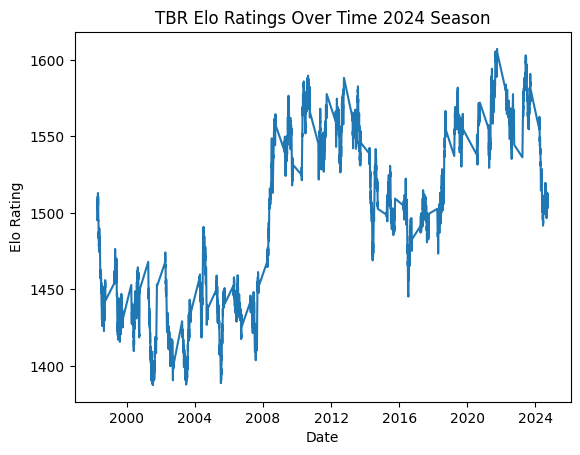

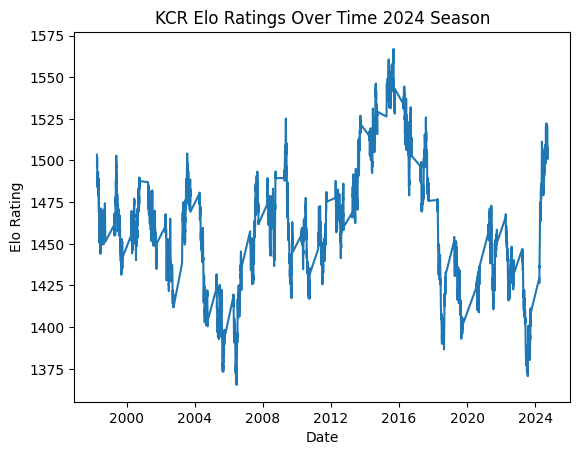

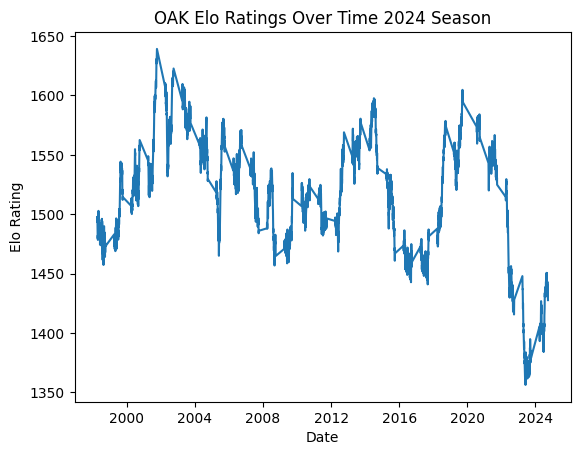

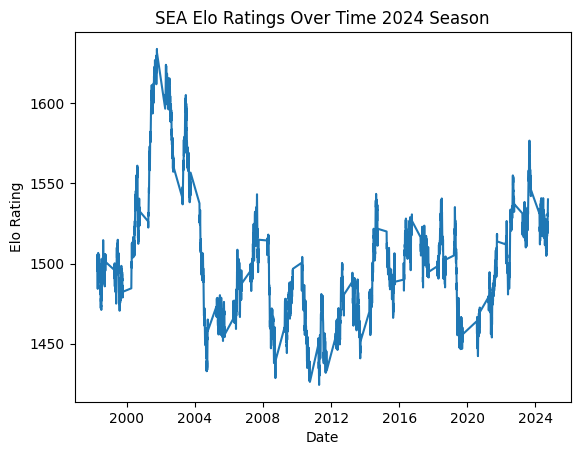

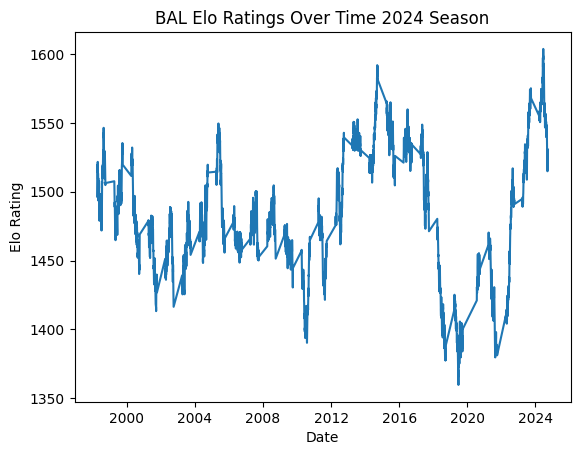

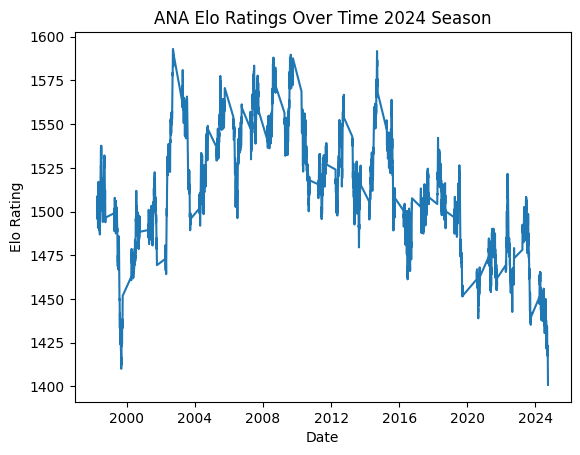

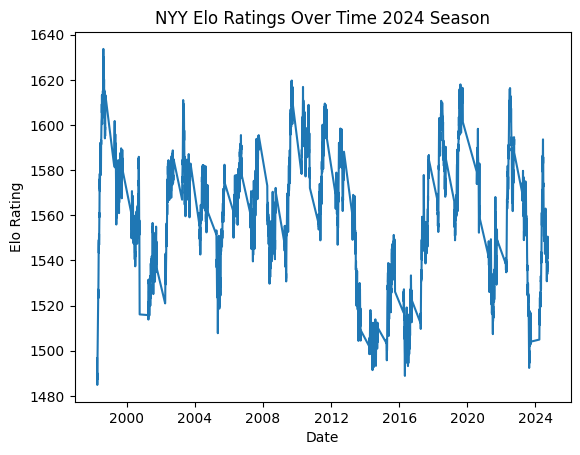

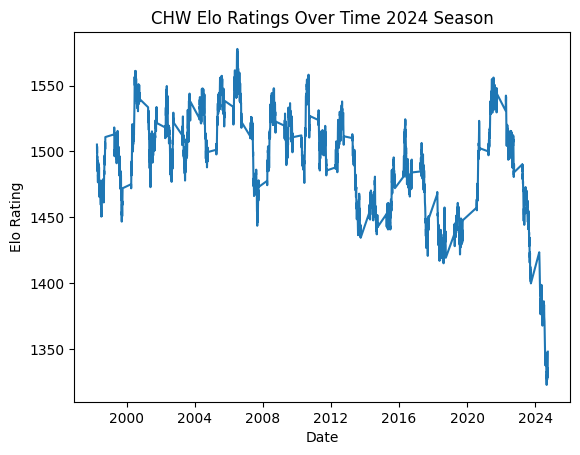

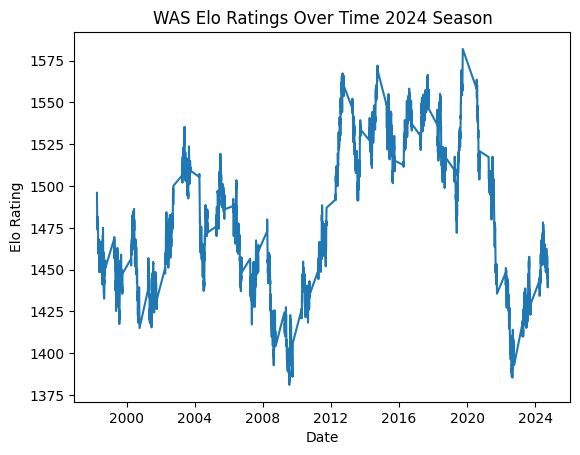

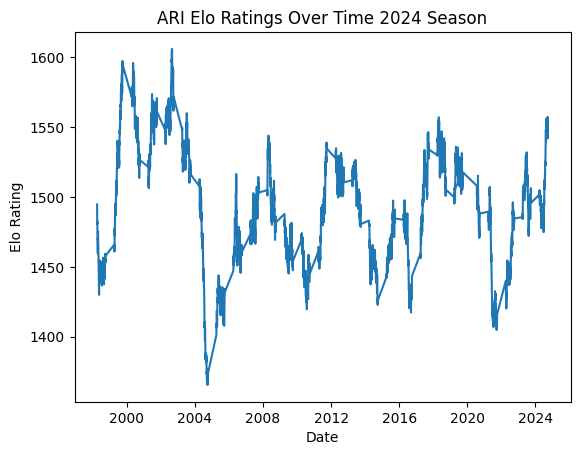

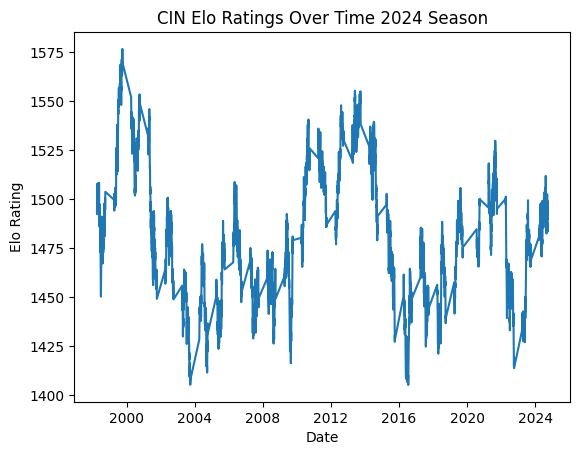

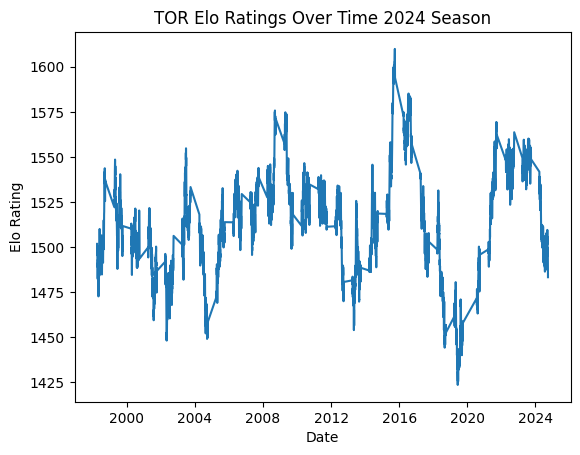

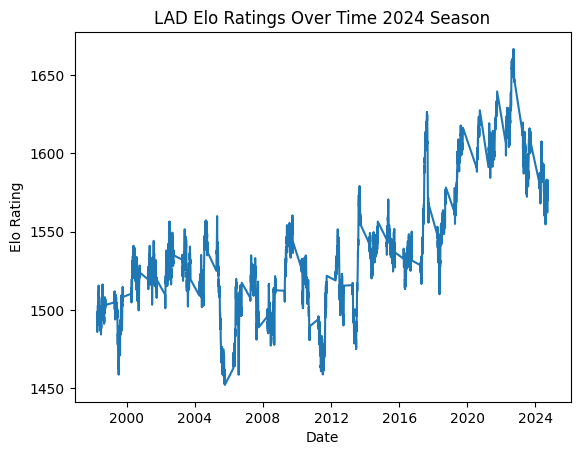

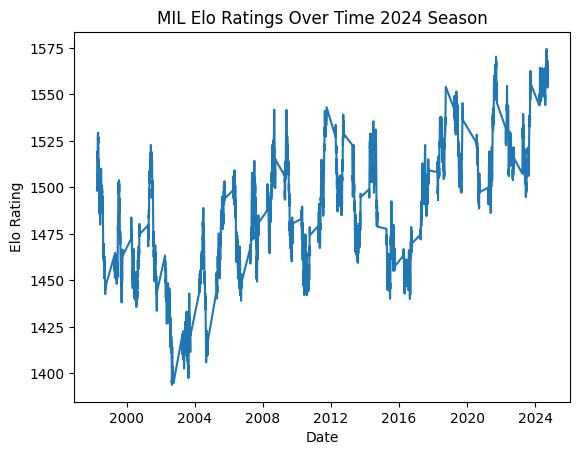

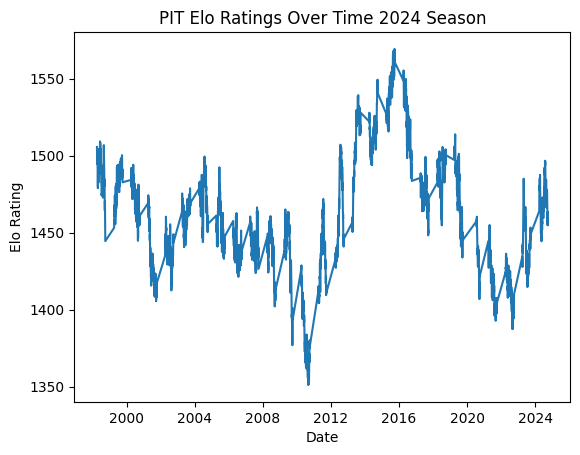

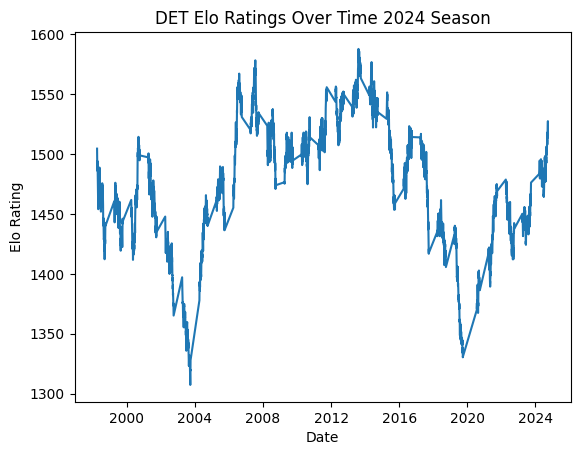

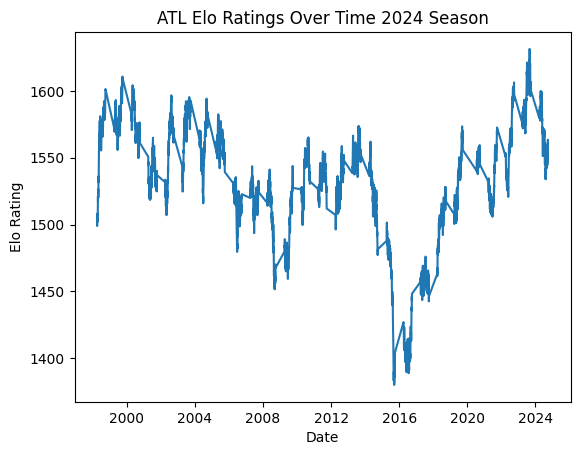

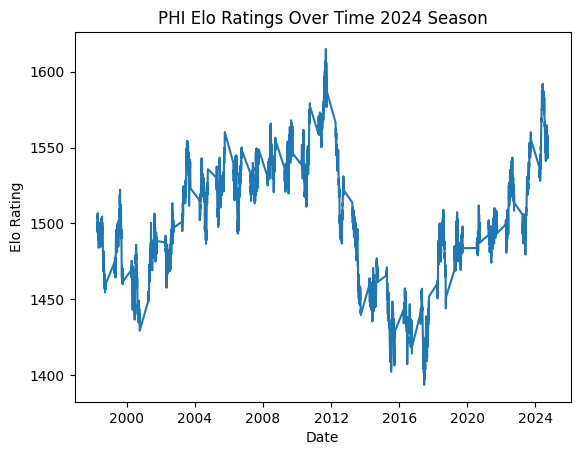

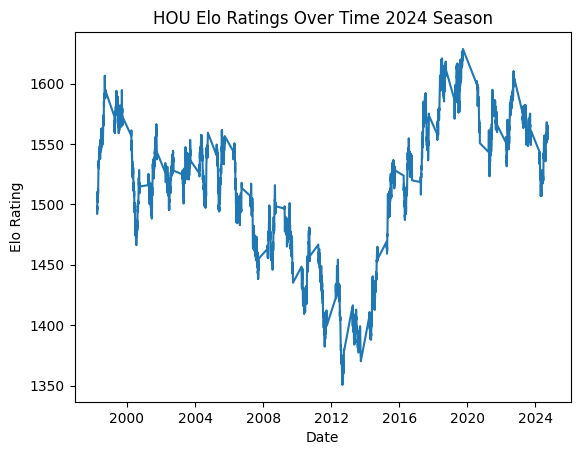

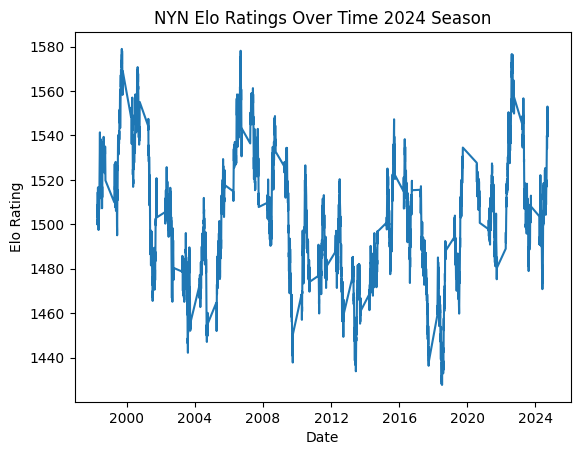

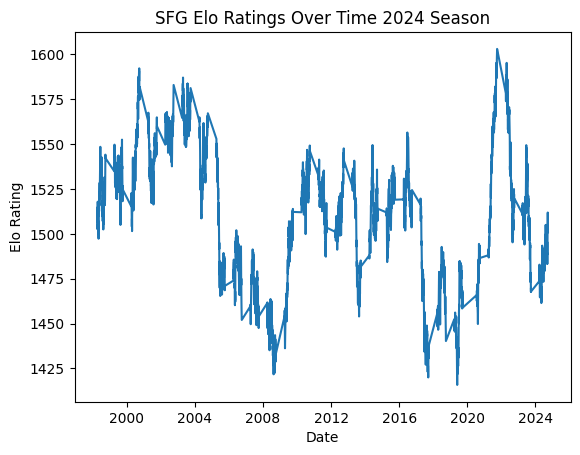

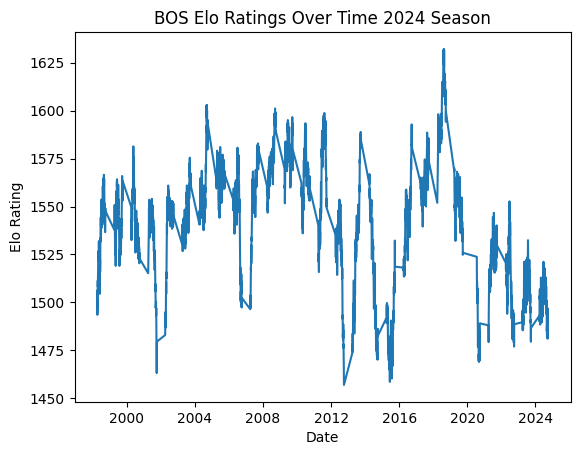

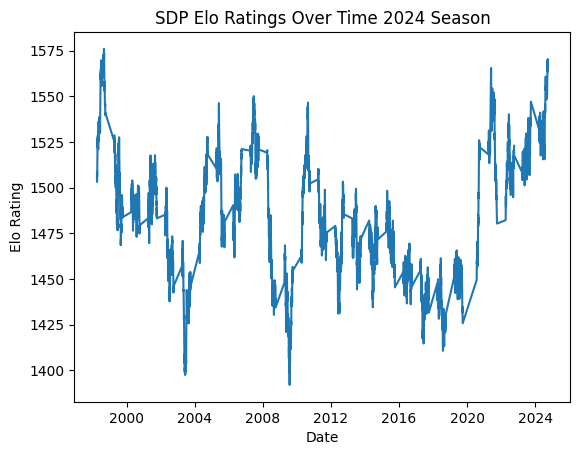

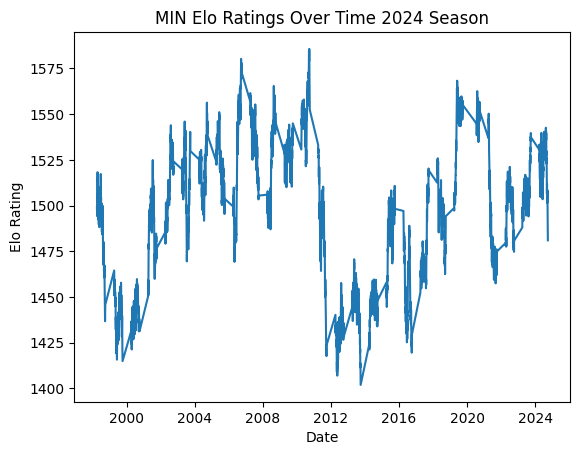

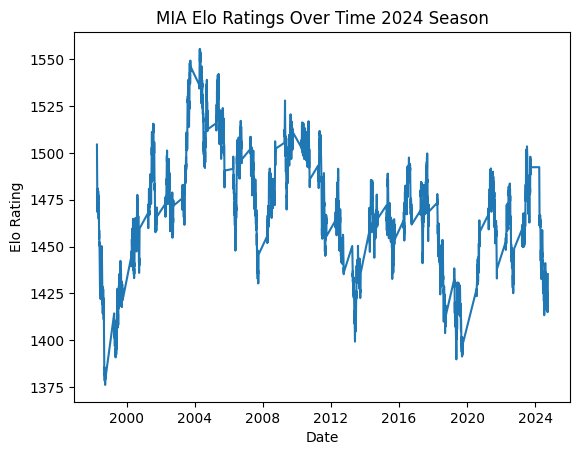

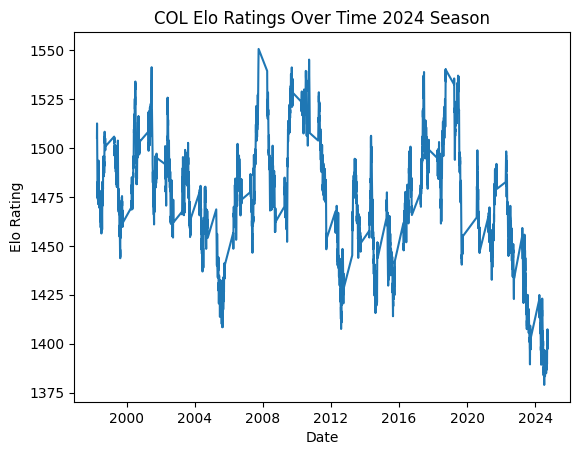

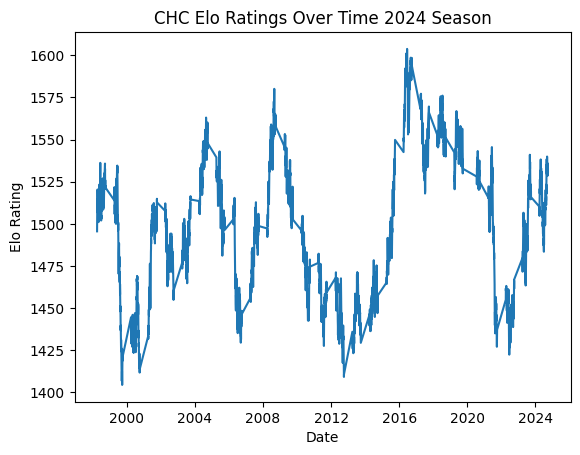

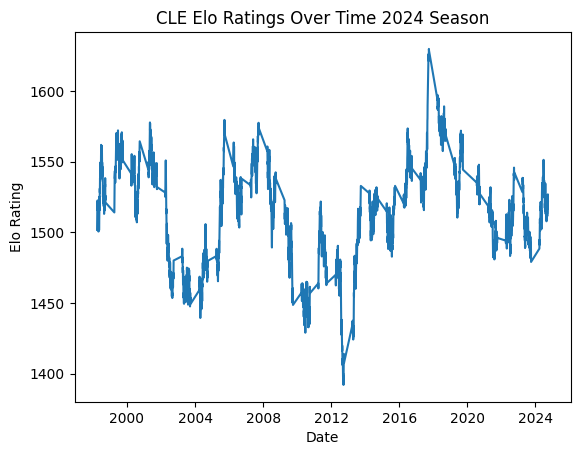

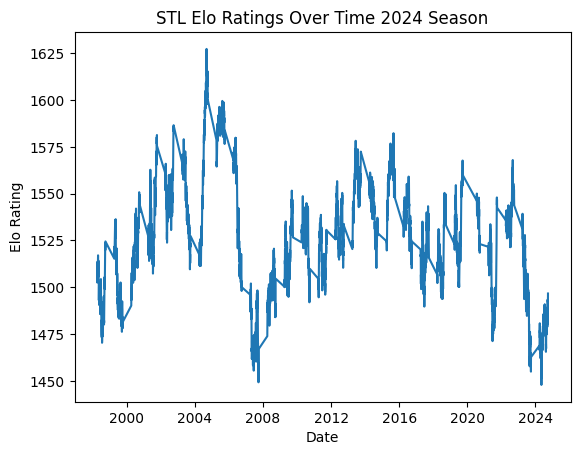

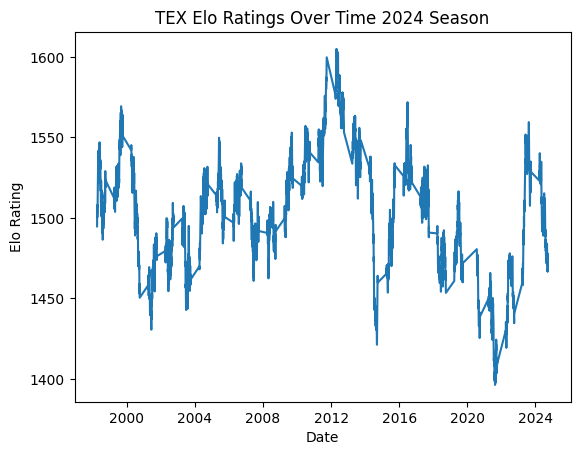

In [79]:
for team in teams:
    team_df = team_history_df.filter(pl.col("team") == team)
    plt.plot(
        team_df.select(pl.col("game_datetime")),
        team_df.select(pl.col("elo")),
        label=team,
    )
    plt.xlabel("Date")
    plt.ylabel("Elo Rating")
    plt.title(f"{team} Elo Ratings Over Time 2024 Season")
    plt.show()

In [80]:
# Print end of season Elo ratings for all teams
print("End of Timeframe Elo Ratings:")
print("-" * 30)
for team, elo in sorted(ratings.items(), key=lambda x: x[1], reverse=True):
    print(f"{team}: {elo:.2f}")

End of Timeframe Elo Ratings:
------------------------------
LAD: 1582.67
SDP: 1564.22
MIL: 1562.42
ATL: 1561.83
HOU: 1558.76
ARI: 1548.30
PHI: 1545.69
NYN: 1543.22
NYY: 1543.20
SEA: 1540.05
CHC: 1531.09
BAL: 1530.56
CLE: 1522.19
DET: 1516.37
TBR: 1507.87
KCR: 1506.88
SFG: 1500.92
STL: 1496.68
BOS: 1489.32
CIN: 1487.39
TOR: 1483.21
MIN: 1480.93
TEX: 1477.14
PIT: 1461.48
WAS: 1447.97
MIA: 1435.34
OAK: 1427.58
ANA: 1400.89
COL: 1397.60
CHW: 1348.22


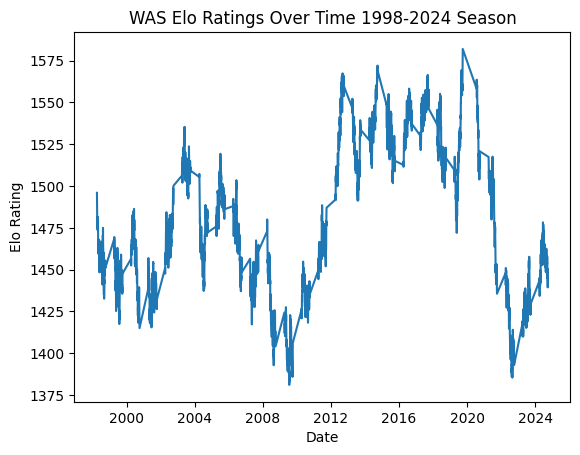

In [81]:
nats_df = team_history_df.filter(pl.col("team") == "WAS")
plt.plot(
    nats_df.select(pl.col("game_datetime")),
    nats_df.select(pl.col("elo")),
    label="WAS",
)
plt.xlabel("Date")
plt.ylabel("Elo Rating")
plt.title("WAS Elo Ratings Over Time 1998-2024 Season")
plt.show()

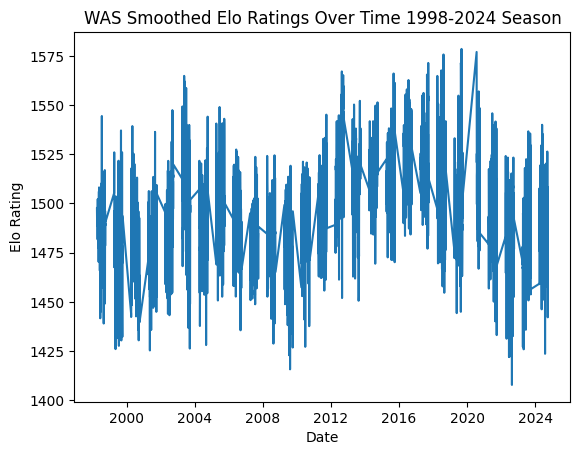

In [82]:
plt.plot(
    nats_df.select(pl.col("game_datetime")),
    nats_df.select(pl.col("smoothed_elo")),
    label="WAS",
)
plt.xlabel("Date")
plt.ylabel("Elo Rating")
plt.title("WAS Smoothed Elo Ratings Over Time 1998-2024 Season")
plt.show()